#Import

In [1]:
!pip install -q keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 11.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Input, LSTM, GRU
from tensorflow.keras.optimizers import Adam

import keras_tuner as kt

import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import seaborn as sns

import random


checkpoint_dir = '/content/drive/MyDrive/maga/checkpoints'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#model.load_weights(checkpoint_dir + checkpoint_name)

# Functions

In [5]:
def mae_plot(plot_name, hist_df):
  sns.set_style("whitegrid")
  fig, ax = plt.subplots(figsize=(8, 5))
  ax = sns.lineplot(data=hist_df['mae'], label='Train MAE', color='lightblue')
  ax = sns.lineplot(data=hist_df['val_mae'], label='Valid. MAE', color='steelblue')
  ax.set_xlim(0, len(hist_df)-1)
  ax.set_title('График значения метрики MAE\nдля тренировочной и валидационной выборки', fontsize=12, fontweight='bold')
  ax.set_xlabel('Номер эпохи', fontsize=12)
  ax.set_ylabel('Значение метрики MAE', fontsize=12)
  if plot_name != None:
    fig.savefig('/content/drive/MyDrive/maga/pic/mae_plot/recurr/' + plot_name + '.png')

def scatter_plot(y_test, y_pred, plot_name):
  sns.set_style("whitegrid")
  fig, ax = plt.subplots(figsize=(8, 5))
  ax = sns.scatterplot(x=y_test[:, 0], y=y_pred[:, 0], alpha=0.5)
  ax = sns.lineplot(x=[0, max(y_test[:, 0])], y=[0, max(y_test[:, 0])], color='black')
  ax.set_xlim(0, max(y_test[:, 0]))
  ax.set_ylim(0, max(y_test[:, 0]))
  ax.set_title('График соответсвия истинных значений предсказанным', fontsize=12, fontweight='bold')
  ax.set_xlabel('Истинные значения', fontsize=12)
  ax.set_ylabel('Предсказанные значения', fontsize=12)
  if plot_name != None:
    fig.savefig('/content/drive/MyDrive/maga/pic/scatter_plot/recurr/alpha_' + plot_name + '.png')

  sns.set_style("whitegrid")
  fig, ax = plt.subplots(figsize=(8, 5))
  ax = sns.scatterplot(x=y_test[:, 1], y=y_pred[:, 1], alpha=0.5)
  ax = sns.lineplot(x=[0, max(y_test[:, 1])], y=[0, max(y_test[:, 1])], color='black')
  ax.set_xlim(0, max(y_test[:, 1]))
  ax.set_ylim(0, max(y_test[:, 1]))
  ax.set_title('График соответсвия истинных значений предсказанным', fontsize=12, fontweight='bold')
  ax.set_xlabel('Истинные значения', fontsize=12)
  ax.set_ylabel('Предсказанные значения', fontsize=12)
  if plot_name != None:
    fig.savefig('/content/drive/MyDrive/maga/pic/scatter_plot/recurr/beta_' + plot_name + '.png')


def line_plot(y_test, y_pred, plot_value, plot_name):
  sns.set_style("whitegrid")
  fig, ax = plt.subplots(figsize=(8, 5))
  ax = sns.lineplot(y_test[0:plot_value, 0], label='Истинные данные', color='steelblue')
  ax = sns.lineplot(y_pred[0:plot_value, 0], label='Предсказанные данные', color='red')
  ax.set_xlim(0, plot_value)
  ax.set_title('График соответсвия истинных данных предсказанным', fontsize=12, fontweight='bold')
  ax.set_xlabel('Количество данных', fontsize=12)
  ax.set_ylabel('Значение данных', fontsize=12)
  if plot_name != None:
    fig.savefig('/content/drive/MyDrive/maga/pic/line_plot/recurr/alpha_' + plot_name + '.png')

  sns.set_style("whitegrid")
  fig, ax = plt.subplots(figsize=(8, 5))
  ax = sns.lineplot(y_test[0:plot_value, 1], label='Истинные данные', color='steelblue')
  ax = sns.lineplot(y_pred[0:plot_value, 1], label='Предсказанные данные', color='red')
  ax.set_xlim(0, plot_value)
  ax.set_title('График соответсвия истинных данных предсказанным', fontsize=12, fontweight='bold')
  ax.set_xlabel('Количество данных', fontsize=12)
  ax.set_ylabel('Значение данных', fontsize=12)
  if plot_name != None:
    fig.savefig('/content/drive/MyDrive/maga/pic/line_plot/recurr/beta_' + plot_name + '.png')

def print_metrics(y_test, y_pred, X_train, csv_name):
  test_results = {}
  test_results['train_size0'] = X_train.shape[0]
  test_results['train_size1'] = X_train.shape[1]
  test_results['lmbd_val'] = y_test.max()
  test_results['mse_alpha'] = mean_squared_error(y_test[:,0], y_pred[:,0])
  test_results['mae_alpha'] = mean_absolute_error(y_test[:,0], y_pred[:,0])
  test_results['r2_alpha'] = r2_score(y_test[:,0], y_pred[:,0])
  test_results['mse_beta'] = mean_squared_error(y_test[:,1], y_pred[:,1])
  test_results['mae_beta'] = mean_absolute_error(y_test[:,1], y_pred[:,1])
  test_results['r2_beta'] = r2_score(y_test[:,1], y_pred[:,1])
  print(test_results)
  if csv_name != None:
    metrics_df = pd.DataFrame(test_results, index=['metrics']).T
    metrics_df.to_csv('/content/drive/MyDrive/maga/metrics/recurr/' + csv_name + '.csv')

def save_load_history(history, history_dir, save_flag):
  if save_flag:
    hist_df = pd.DataFrame(history.history)
    with open('/content/drive/MyDrive/maga/history/recurr/history_' + history_dir, mode='w') as f:
      hist_df.to_csv(f)
  else:
    hist_df = pd.read_csv('/content/drive/MyDrive/maga/history/recurr/history_' + history_dir, sep=',', engine='python', index_col=0)
    return hist_df

def reccur_potok(alpha, beta):
  time_event = random.gammavariate(alpha, beta)
  return(time_event)

def gen_recurr(row, col):
  time_list = np.zeros([row, col])
  alpha_list = []
  beta_list = []

  for i in range(row):
    counter = 0
    T = 0
    time = 0
    alpha_list.append(y_pred[i][0])
    beta_list.append(y_pred[i][1])
    for j in range(col):
      T = reccur_potok(abs(y_pred[i][0]), abs(y_pred[i][1]))
      time += T
      time_list[i][j] = time
      counter += 1

  df_prov = pd.DataFrame(time_list)
  df_prov['alpha_value'] = alpha_list
  df_prov['beta_value'] = beta_list
  return df_prov



def print_curve_metrics(X_test_interval, df_prov_interval, itog_itog_list, csv_name):
  relative_error_mean_list = []
  relative_error_std_list = []
  for i in range(X_test_interval.shape[0]):
    relative_error_mean_list.append(abs(X_test_interval.iloc[i].mean() - df_prov_interval.iloc[i].mean()) / X_test_interval.iloc[i].mean())
    relative_error_std_list.append(abs(X_test_interval.iloc[i].std() - df_prov_interval.iloc[i].std()) / X_test_interval.iloc[i].std())

  abs_list = []
  abs_itog_list = itog_itog_list
  for i in range(X_test.shape[0]):
    for j in range(X_test.shape[1]):
      abs_itog_list[i][j] = abs(itog_itog_list[i][j])
    abs_list.append(max(itog_itog_list[i]))

  test_results = {}
  test_results['relative_error_mean'] = relative_error_mean_list
  test_results['relative_error_std'] = relative_error_std_list
  test_results['abs_list'] = abs_list

  metrics_df = pd.DataFrame(test_results)

  test_result_mean = {}
  test_result_mean['relative_error_mean_mean'] = metrics_df['relative_error_mean'].mean()
  test_result_mean['relative_error_mean_median'] = metrics_df['relative_error_mean'].median()
  test_result_mean['relative_error_std_mean'] = metrics_df['relative_error_std'].mean()
  test_result_mean['relative_error_std_median'] = metrics_df['relative_error_std'].median()
  test_result_mean['abs_mean'] = metrics_df['abs_list'].mean()
  test_result_mean['abs_median'] = metrics_df['abs_list'].median()

  metrics_mean_df = pd.DataFrame([test_result_mean])

  print(metrics_mean_df)

  if csv_name != None:
    metrics_df.to_csv('/content/drive/MyDrive/maga/metrics/recurr/curve_interval_metrics_' + csv_name + '.csv')
    metrics_mean_df.to_csv('/content/drive/MyDrive/maga/metrics/recurr/curve_interval_mean_metrics_' + csv_name + '.csv')


def draw_curve(x_value, pic_value, X_test, df_prov):
  y = range(0, x_value)

  for i in range(pic_value):
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(8, 5))
    ax = sns.lineplot(x = X_test[i, :x_value], y=y, drawstyle='steps-pre', label='Смоделированная')
    ax = sns.lineplot(x = np.array(df_prov.iloc[i:i+1, :x_value])[0], y=y, drawstyle='steps-pre', label='Оцененная')
    ax.legend(loc = 4)
    ax.set_xlim(0, max(max(X_test[i, :x_value]), max(np.array(df_prov.iloc[i:i+1, :x_value])[0])))
    ax.set_ylim((0, x_value))
    ax.set_title('Сравнение смоделированной и оценной кривой', fontsize=12, fontweight='bold')
    ax.set_xlabel('Время', fontsize=12)
    ax.set_ylabel('Шаг', fontsize=12);

# Read and split data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/maga/dataset/dataset_recurr3.csv', sep=',', index_col=0)

In [ ]:
Q1 = df['beta_value'].quantile(0.25)
Q3 = df['beta_value'].quantile(0.75)
IQR = Q3 - Q1

In [ ]:
df = df[(df['beta_value'] < (Q3+1.5*IQR))]

In [ ]:
df['alpha_value'].hist()

In [ ]:
df['beta_value'].hist()

In [ ]:
df = df[df['lmbd'] < 0.05]

<Axes: >

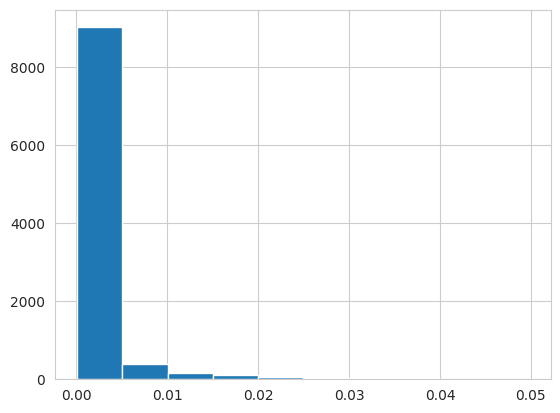

In [ ]:
df['lmbd'].hist()

In [ ]:
X = df.drop(['alpha_value', 'beta_value', 'lmbd'], axis=1)
y = df[['alpha_value', 'beta_value']]

In [ ]:
X_list = []

In [ ]:
for i in range(1, X.shape[1]):
  X_list.append(X[str(i)] - X[str(i-1)])

In [ ]:
X = pd.DataFrame(np.array(X_list).T.tolist())

In [ ]:
X, y = np.array(X), np.array(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
y_train_scaled = scaler.fit_transform(y_train)

# Tune

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
from tensorflow.keras import regularizers

In [ ]:
def build_model(hp):
    dnn_layers_ss = [1,2,3,4,5]
    dnn_units_min, dnn_units_max = 32, 1024
    active_func_ss = ['relu', 'sigmoid', 'selu']
    optimizer_ss = ['adam']
    lr_min, lr_max = 1e-4, 1e-1
    dropout_value = [0.1, 0.2, 0.3, 0.4]

    active_func = hp.Choice('activation', active_func_ss)
    optimizer = hp.Choice('optimizer', optimizer_ss)
    lr = hp.Float('learning_rate', min_value=lr_min, max_value=lr_max, sampling='log')
    drop = hp.Choice('rate', dropout_value)

    inputs = Input(shape=(X_train.shape[1],))

    # create hidden layers
    dnn_units = hp.Int(f"0_units", min_value=dnn_units_min, max_value=dnn_units_max)
    dense = Dense(units=dnn_units, activation=active_func)(inputs)
    for layer_i in range(hp.Choice("n_layers", dnn_layers_ss) - 1):
        dnn_units = hp.Int(f"{layer_i}_units", min_value=dnn_units_min, max_value=dnn_units_max)
        dense = Dense(units=dnn_units, activation=active_func, kernel_regularizer=regularizers.l2(0.01))(dense)
        if hp.Boolean("dropout"):
          Dropout(rate=drop)(dense)
    outputs = Dense(units=2)(dense)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='mse',
                  metrics='mae')
    return model
    #, kernel_regularizer=regularizers.l2(0.001)

# Tune Hyperband

In [ ]:
tuner = kt.Hyperband(build_model,
                     objective='val_mae',
                     overwrite=True,
                     max_epochs=5,
                     factor=3,
                     directory='/content/drive/MyDrive/maga/tune',
                     project_name='recurr_reg_hyperband_1')

NameError: ignored

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=3)

In [ ]:
tuner.search(
    X_train_scaled,
    y_train,
    epochs=5,
    validation_split=0.2,
    callbacks=[stop_early],
)

# Tune Bayesian

In [ ]:
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_mae',
    max_trials=30,
    overwrite=True,
    directory='/content/drive/MyDrive/maga/tune',
    project_name='recur_bayesian_3000')

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=3)

In [ ]:
tuner.search(
    X_train_scaled,
    y_train_scaled,
    epochs=5,
    validation_split=0.2,
    callbacks=[stop_early],
)

Trial 30 Complete [00h 00m 14s]
val_mae: 0.13651128113269806

Best val_mae So Far: 0.12058740854263306
Total elapsed time: 00h 09m 23s


# My model

In [ ]:
{'activation': 'selu',
 'optimizer': 'adam',
 'learning_rate': 0.0005792191172368308,
 'rate': 0.3,
 '0_units': 567,
 'n_layers': 5,
 'dropout': False,
 '1_units': 1006,
 '2_units': 39,
 '3_units': 474}

In [ ]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(567, input_dim=X_train[0].shape[0], kernel_initializer='he_uniform', activation="selu"),
    Dense(1006, activation="selu", kernel_regularizer=regularizers.l2(0.001)),
    Dense(139, activation="selu", kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.25),
    Dense(139, activation="selu", kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.15),
    Dense(474, activation="selu", kernel_regularizer=regularizers.l2(0.001)),
    Dense(2, activation=None)
])


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='mse',
                  metrics='mae')

# Train model

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
best_hps.values

{'activation': 'relu',
 'optimizer': 'adam',
 'learning_rate': 0.004375574041239932,
 'rate': 0.2,
 '0_units': 250,
 'n_layers': 3,
 'dropout': True,
 '1_units': 421,
 '2_units': 622}

In [ ]:
best_model = tuner.get_best_models()[0]

best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2999)]            0         
                                                                 
 dense (Dense)               (None, 250)               750000    
                                                                 
 dense_1 (Dense)             (None, 250)               62750     
                                                                 
 dense_2 (Dense)             (None, 421)               105671    
                                                                 
 dense_3 (Dense)             (None, 2)                 844       
                                                                 
Total params: 919,265
Trainable params: 919,265
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def myprint(s):
    with open('/content/drive/MyDrive/maga/model_summary/recurr_reg_interval_bayesian_3layers_70epochs_3000_uni.txt','a') as f:
        print(s, file=f)

best_model.summary(print_fn=myprint)

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/maga/checkpoints/recurr'
checkpoint_name = '/recurr_reg_interval_bayesian_3layers_70epochs_3000_uni_exp'

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir + checkpoint_name,
                                                 monitor='val_mae',
                                                 save_weights_only=False,
                                                 verbose=1)

In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_scaled, y_train_scaled, epochs=150, validation_split=0.2, shuffle=True)
#, callbacks=[cp_callback]

Epoch 1/150
200/200 [==============================] - 3s 10ms/step - loss: 0.2375 - mae: 0.1390 - val_loss: 0.0369 - val_mae: 0.1317
Epoch 2/150
200/200 [==============================] - 2s 8ms/step - loss: 0.0354 - mae: 0.1291 - val_loss: 0.0419 - val_mae: 0.1332
Epoch 3/150
200/200 [==============================] - 2s 8ms/step - loss: 0.0302 - mae: 0.1156 - val_loss: 0.0387 - val_mae: 0.1347
Epoch 4/150
200/200 [==============================] - 2s 8ms/step - loss: 0.0228 - mae: 0.0918 - val_loss: 0.0394 - val_mae: 0.1256
Epoch 5/150
200/200 [==============================] - 1s 7ms/step - loss: 0.0181 - mae: 0.0760 - val_loss: 0.0353 - val_mae: 0.1207
Epoch 6/150
200/200 [==============================] - 1s 7ms/step - loss: 0.0158 - mae: 0.0699 - val_loss: 0.0363 - val_mae: 0.1238
Epoch 7/150
200/200 [==============================] - 2s 9ms/step - loss: 0.0140 - mae: 0.0645 - val_loss: 0.0347 - val_mae: 0.1225
Epoch 8/150
200/200 [==============================] - 2s 11ms/step 

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/maga/checkpoints/recurr/recurr_reg_interval_bayesian_3layers_150epochs_1000')

In [ ]:
y_pred = model.predict(X_test_scaled)

63/63 [==============================] - 0s 4ms/step


In [ ]:
y_pred = scaler.inverse_transform(y_pred)

In [ ]:
print_metrics(y_test, abs(y_pred), X_train, None)

{'train_size0': 8000, 'train_size1': 2999, 'lmbd_val': 99.9255560425372, 'mse_alpha': 0.00016648329797820825, 'mae_alpha': 0.008618696157005749, 'r2_alpha': -0.6453114884211459, 'mse_beta': 820.3600005159108, 'mae_beta': 22.057615118304195, 'r2_beta': 0.03073998338036288}


In [ ]:
hist_df = pd.DataFrame(history.history)

In [ ]:
save_load_history(history, 'recurr_reg_interval_bayesian_3layers_70epochs_3000_uni_without_outliers_45_47', True)

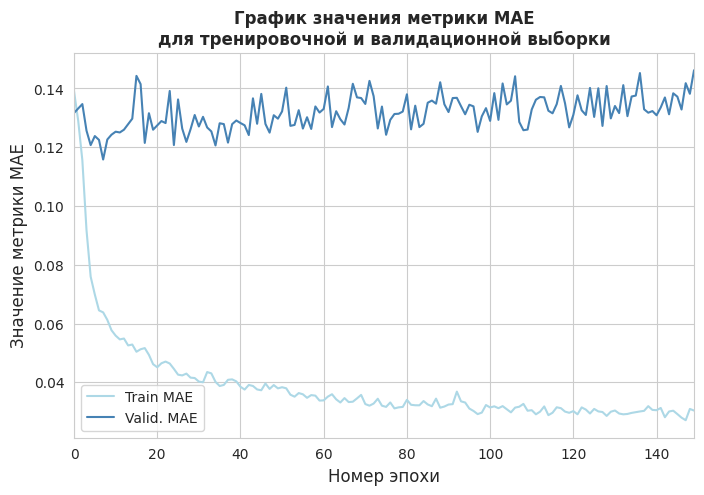

In [ ]:
#'recurr_reg_interval_bayesian_5layers_150epochs_15000_33_32'
mae_plot(None, hist_df)

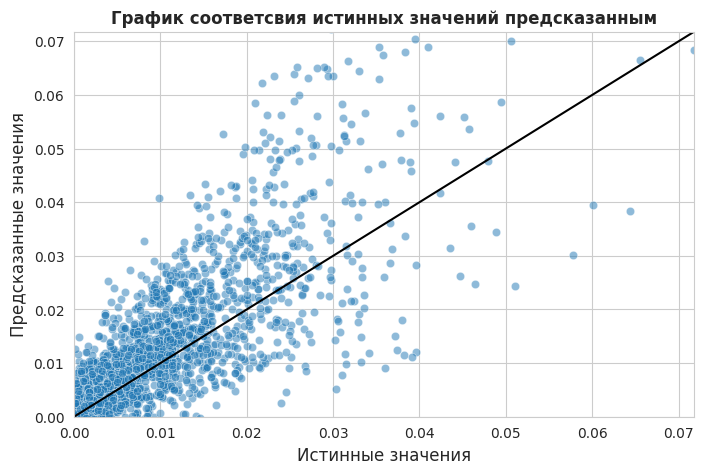

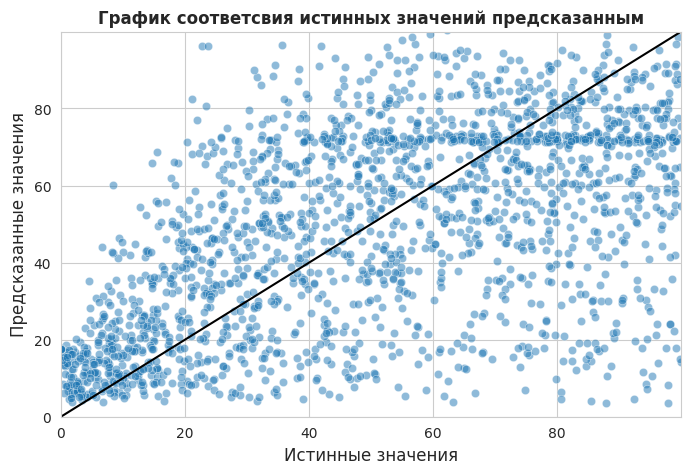

In [ ]:
scatter_plot(y_test, y_pred, None)

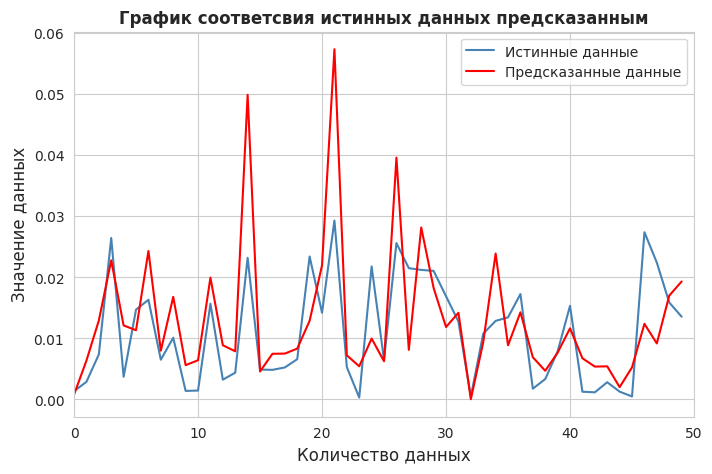

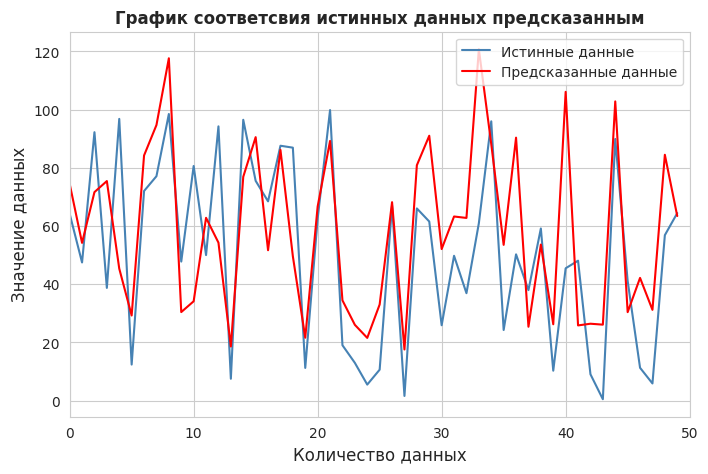

In [ ]:
line_plot(y_test, y_pred, 50, None)

# Compare curve

In [ ]:
X = df.drop(['alpha_value', 'beta_value', 'lmbd'], axis=1)
y = df[['alpha_value', 'beta_value']]

In [ ]:
X, y = np.array(X), np.array(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [ ]:
df_prov = gen_recurr(X_test.shape[0], X_test.shape[1])

In [ ]:
df_prov_list = []

In [ ]:
for i in range(1, df_prov.shape[1]-2):
  df_prov_list.append(df_prov[i] - df_prov[i-1])

In [ ]:
df_prov_interval = pd.DataFrame(np.array(df_prov_list).T.tolist())

In [ ]:
X_test_interval = pd.DataFrame(X_test)

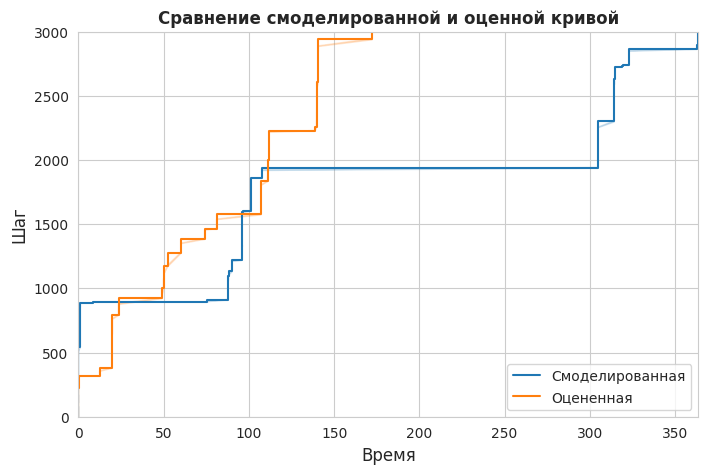

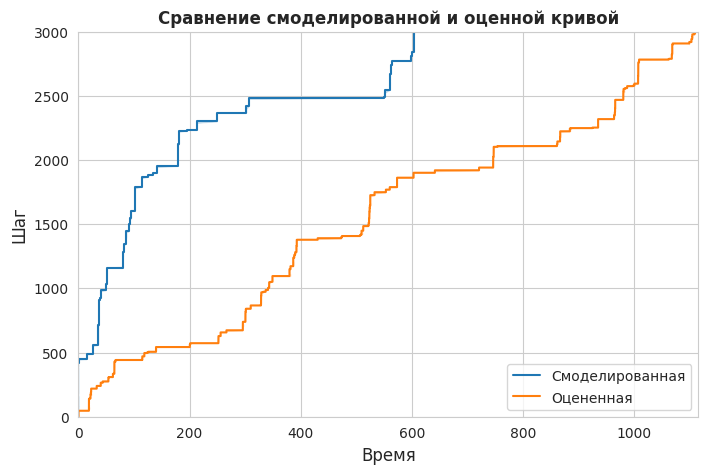

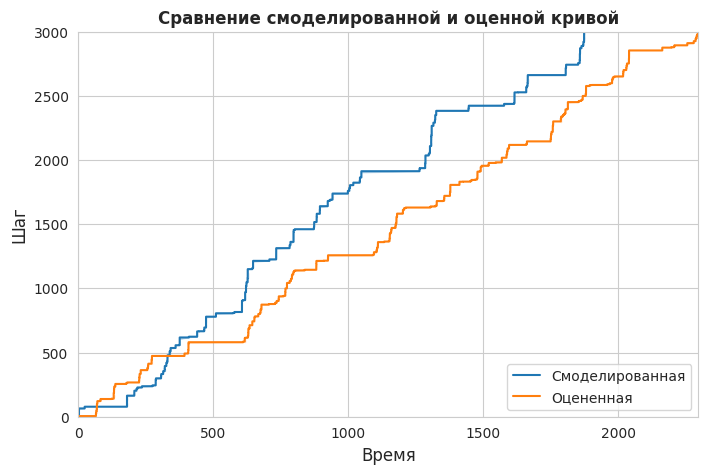

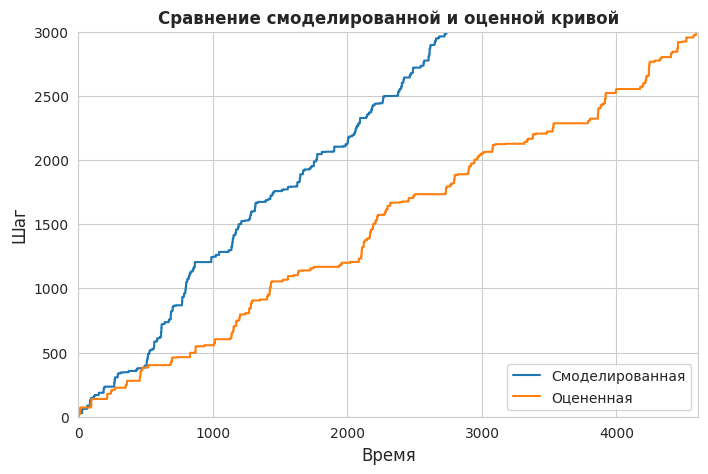

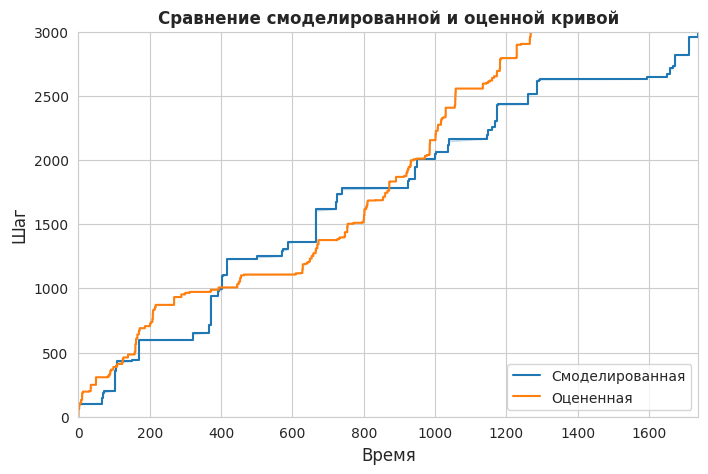

In [ ]:
draw_curve(X_test.shape[1], 5, X_test, df_prov)

In [ ]:
a = X_test[0:X_test.shape[0], :X_test.shape[1]]
b = np.array(df_prov.iloc[0:X_test.shape[0], :X_test.shape[1]])

In [ ]:
itog_itog_list = []

for i in range(X_test.shape[0]):
  counter1 = 0
  counter2 = 0
  itog_list = []

  if max(a[i]) > max(b[i]):
    while counter2 < X_test.shape[1]:
      if a[i][counter1] < b[i][counter2]:
        counter1 += 1
        itog_list.append(abs(counter1 - counter2))
      elif a[i][counter1] > b[i][counter2]:
        counter2 += 1
        itog_list.append(abs(counter1 - counter2))
      else:
        counter1 += 1
        counter2 += 1
        itog_list.append(abs(counter1 - counter2))
    itog_itog_list.append(itog_list)
  else:
    while counter1 < X_test.shape[1]:
      if a[i][counter1] < b[i][counter2]:
        counter1 += 1
        itog_list.append(abs(counter1 - counter2))
      elif a[i][counter1] > b[i][counter2]:
        counter2 += 1
        itog_list.append(abs(counter1 - counter2))
      else:
        counter1 += 1
        counter2 += 1
        itog_list.append(abs(counter1 - counter2))
    itog_itog_list.append(itog_list)

In [ ]:
print_curve_metrics(X_test_interval, df_prov_interval, itog_itog_list, None)

   relative_error_mean_mean  relative_error_mean_median  \
0              2.873422e+82                    0.998805   

   relative_error_std_mean  relative_error_std_median  abs_mean  abs_median  
0             6.933129e+83                   0.981805  1573.715      1447.0  


In [ ]:
print_curve_metrics(X_test_interval, df_prov_interval, itog_itog_list, 'recurr_reg_interval_bayesian_2layers_150epochs_1000_35_38')

   relative_error_mean_mean  relative_error_mean_median  \
0              2.873422e+82                    0.998805   

   relative_error_std_mean  relative_error_std_median  abs_mean  abs_median  
0             6.933129e+83                   0.981805  1573.715      1447.0  
